In [32]:
from typing import Any
import json
import pandas as pd
from datasets import load_from_disk
import multiprocessing
from functools import reduce
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
metrics = ["f1", "accuracy", "matthews_correlation"]

In [33]:
PHENOMENA = ["synonym", "antonym", "hypernym", "hyponym", "co_hyponym", "quantifiers", "numericals"]
EXPLAINERS = ["shap", "lime", "integrated gradient", "integrated gradient multiply by inputs"]
EXPLAINER_NAMES = ["shap", "lime", "ig", "igmby"]
EVALUATORS = ["comprehensiveness", "sufficency", "tauloo", "auprc plausibility", "f1 plausibility", "iou plausibility"]

# Notebooks run on last, so path is also on last
DATASET_PATH = "/mnt/semproj/sem_proj22/proj_05/data/datasets/esnli_evaluations_42_phenomena"

In [51]:
def plot_heatmap(data):  
    sns.set(font_scale=1.4)
    ax = sns.heatmap(data, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt=".4f")
    ax.set(xlabel='Explainer', ylabel='Evaluator')
    ax.xaxis.set_label_position('top')
    plt.tick_params(axis='both', which='major', labelbottom=False, bottom=False, top=False, labeltop=True)
    plt.show()

In [35]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs):
    output = ""
    #df_dicts = dict(dfs)
    for df in dfs:
        output += df.style.set_table_attributes("style='display:inline'").set_caption(df.name)._repr_html_()
        output += "<br><br>"
    display(HTML(output))

In [36]:
dataset = load_from_disk(DATASET_PATH)

In [37]:
def construct_metrics_by_phenomenon(dataset, phenomenon):
    cpu_count = multiprocessing.cpu_count()
    def phenomenon_filter(record):
        return record[phenomenon] > 0
    return dataset.filter(phenomenon_filter, num_proc=cpu_count).to_pandas()["evaluations"]
    

def construct_phenomena_metrics(dataset, phenomena):
    return {phenomenon: construct_metrics_by_phenomenon(dataset, phenomenon) for phenomenon in phenomena}

def construct_phenomena_dfs(metrics):
    def bake_df(series, name):
        df = series.to_frame()
        df.name = name
        return df.evaluations
    return [bake_df(series, name) for name, series in metrics.items()]

In [38]:
phenomena_metrics = construct_phenomena_metrics(dataset, PHENOMENA)
phenomena_metrics = construct_phenomena_dfs(phenomena_metrics)

Loading cached processed dataset at /mnt/semproj/sem_proj22/proj_05/data/datasets/esnli_evaluations_42_phenomena/cache-a60c1a6868558075_*_of_00040.arrow
Loading cached processed dataset at /mnt/semproj/sem_proj22/proj_05/data/datasets/esnli_evaluations_42_phenomena/cache-ebbc902d29d7348c_*_of_00040.arrow
Loading cached processed dataset at /mnt/semproj/sem_proj22/proj_05/data/datasets/esnli_evaluations_42_phenomena/cache-6bee68742a3f0052_*_of_00040.arrow
Loading cached processed dataset at /mnt/semproj/sem_proj22/proj_05/data/datasets/esnli_evaluations_42_phenomena/cache-b5554dade6f4d8a8_*_of_00040.arrow
Loading cached processed dataset at /mnt/semproj/sem_proj22/proj_05/data/datasets/esnli_evaluations_42_phenomena/cache-9d39a1496f3b5cd0_*_of_00040.arrow
Loading cached processed dataset at /mnt/semproj/sem_proj22/proj_05/data/datasets/esnli_evaluations_42_phenomena/cache-7775e3ca46dfcc2e_*_of_00040.arrow
Loading cached processed dataset at /mnt/semproj/sem_proj22/proj_05/data/datasets/

In [39]:
def add_record_labels(records, explainer_labels, evaluator_labels):
    def add_evaluation_labels(explanation):
        return {name: evaluation for name, evaluation in zip(evaluator_labels, explanation)}
    def add_explainer_labels(record):
        return {name: add_evaluation_labels(explanation) for name, explanation in zip(explainer_labels, record)}
    return [add_explainer_labels(record) for record in records]


# Calculate sum, then divide by len, so that I do not need to read every
def record_mean(records):
    item_count = len(records)
    def sum_records(r1, r2):
        return [
            [
                r1_explanation + r2_explanation
                for r1_explanation, r2_explanation in zip(r1_evaluation, r2_evaluation)
            ]
            for r1_evaluation, r2_evaluation in zip(r1, r2)
        ]
    def finish_mean(input):
        return [
            [
                explanation / item_count
                for explanation in evaluation
            ]
            for evaluation in input
        ]
    aggregated = reduce(sum_records, records)
    return finish_mean(aggregated)

In [40]:
records_mean = [record_mean(phenomena) for phenomena in phenomena_metrics]
labeled_df = add_record_labels(records_mean, EXPLAINERS, EVALUATORS)

In [41]:
def phenomena_label(records):
    return {name: record for name, record in zip(PHENOMENA, records)}

In [42]:
labeled_dict = phenomena_label(labeled_df)

In [49]:
def another_df(phenomenon, item):
    df = pd.DataFrame({k:pd.Series(v) for k,v in item.items()}, EVALUATORS, EXPLAINERS)
    df.name = phenomenon
    df.columns = df.columns = EXPLAINER_NAMES
    return df

display_side_by_side(
    [another_df(phenomenon, single) for phenomenon, single in labeled_dict.items()]
)

,shap,lime,ig,igmby
comprehensiveness,0.518674,0.627070,0.270685,0.459336
sufficency,0.194687,0.157172,0.450657,0.212187
tauloo,0.141419,0.346681,-0.004969,0.230825
auprc plausibility,0.473575,0.525832,0.415022,0.514174
f1 plausibility,0.338560,0.384954,0.281946,0.378026
iou plausibility,0.220787,0.255721,0.176334,0.251202
,shap,lime,ig,igmby
comprehensiveness,0.513498,0.663527,0.286895,0.511958
sufficency,0.290657,0.103894,0.420565,0.167257
tauloo,0.002030,0.244861,-0.004277,0.195421


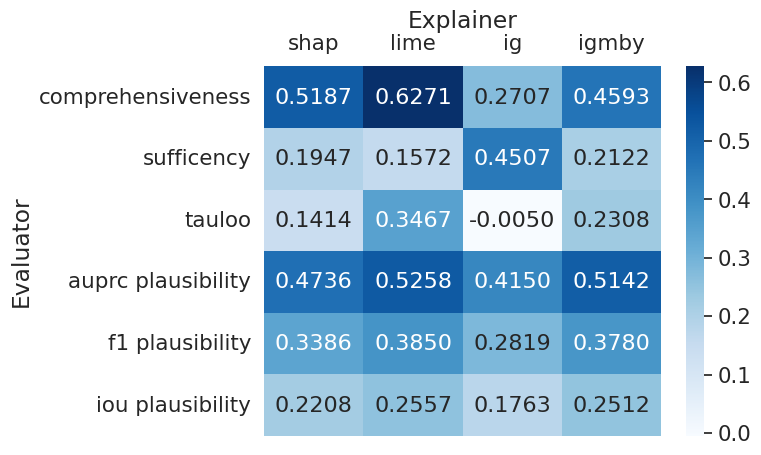

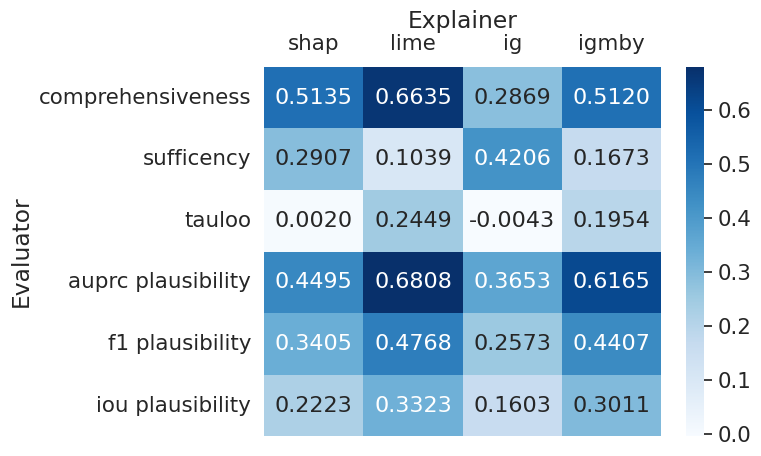

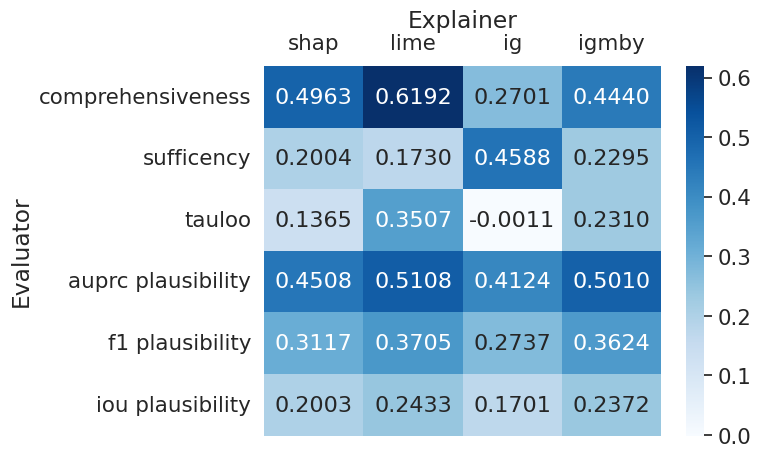

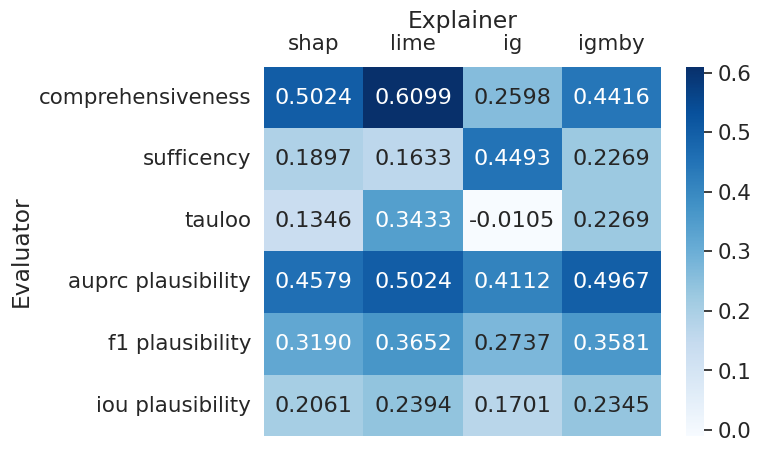

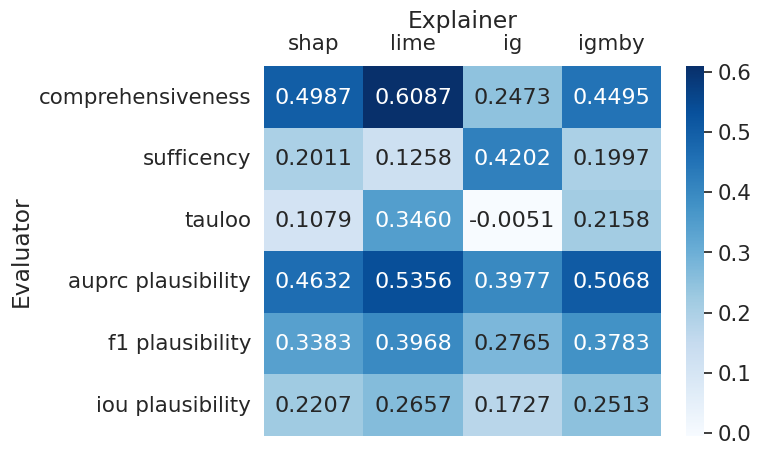

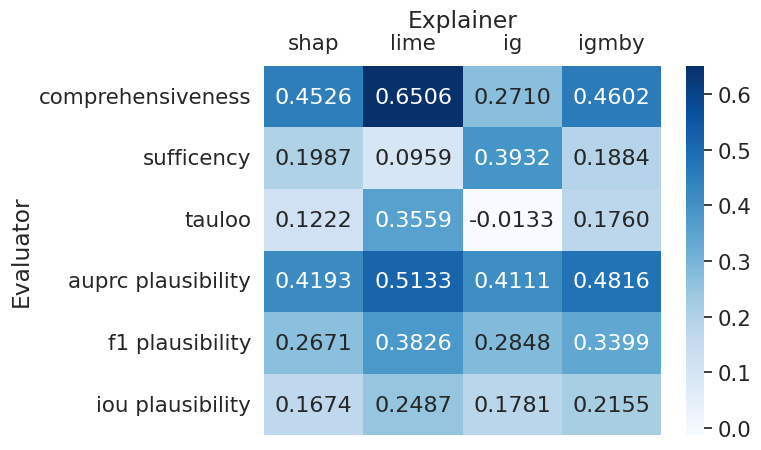

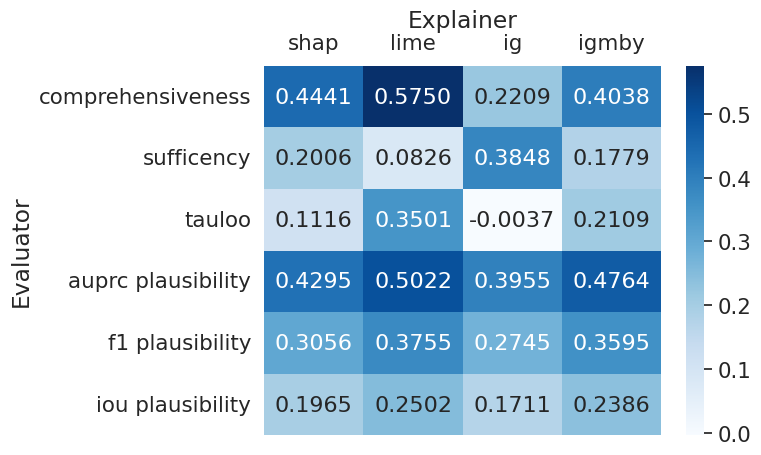

In [52]:
for phenomenon, single in labeled_dict.items():
    plot_heatmap(another_df(phenomenon, single))